In [1]:
# https://realpython.com/k-means-clustering-python/

# Data preprocessing modules 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import matplotlib.gridspec as gridspec

#Data Modelling packages 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split 
from scipy.stats import randint 
    #k-means clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D

#Visualisation for Trees 
from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz 

from scipy import stats

#Database connection
import snowflake.connector

/Users/samorasixaba/anaconda3/lib/python3.11/site-packages/snowflake/connector/options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (16.0.0), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(


In [2]:
# Setting random seed for reproducibility
seed = 42
np.random.seed(seed)

In [3]:
#Creating connection to snowflake database 
conn = snowflake.connector.connect(account='vd06572.eu-west-1',
                                   user= 'VSIXABA',
                                   password= 'Simehlulewam!2013',
                                   database='ANALYTICS') 

In [4]:
df = pd.read_sql_query( 
                      """
WITH
DATA        AS (
SELECT
    DISTINCT
    I.CONSULTATION_ID,
    I.INVOICE_ID,
    I.CREATED_AT,
    II.AMOUNT,
    I.PATIENT_ID,
    II.CONSULTATION_TYPE,
    KT.STATUS,
    KT.PAYMENT_METHOD
    FROM ANALYTICS.PROD.STG_KENA__INVOICES      I
    JOIN ANALYTICS.PROD.STG_KENA__INVOICE_ITEMS II
        ON I.INVOICE_ID = II.INVOICE_ID
    LEFT JOIN ANALYTICS.PROD.STG_KENA__TRANSACTIONS     KT
        ON I.INVOICE_ID = KT.INVOICE_ID
        AND KT.RN = 1
    WHERE II.CONSULTATION_TYPE <> 'scheme_admin_fee'
)
SELECT
    *
    FROM DATA
    WHERE CREATED_AT::DATE <= '2024-08-01'

 """, con = conn)
df.head()

/var/folders/f5/t60lbx3s3z57_j6p74br402w0000gn/T/ipykernel_66642/3836839590.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


,CONSULTATION_ID,INVOICE_ID,CREATED_AT,AMOUNT,PATIENT_ID,CONSULTATION_TYPE,STATUS,PAYMENT_METHOD
0,abbe05e6-7356-4817-9dc8-b98e8ec78236,15163c88-92d1-406b-a2f0-d284280d1a62,2023-09-21 10:22:39.481166,185.0,0ccda91a-476f-44f2-92f1-c112b8db633f,standard,success,Cash Payment
1,91cd9435-704e-4dc4-b52d-ffe921659525,1579c2cc-78a7-4bbf-aeee-6100f9b0be0f,2024-05-20 10:32:41.105772,185.0,48b91a4e-0eae-4dae-ba08-c3eb411a79f5,standard,success,Voucher
2,1ce566d1-9f2e-4742-b471-2a67b464d68d,14999760-e7d2-4ce8-a796-153f959f9c56,2024-03-19 12:34:59.963934,185.0,dc4069ed-5fdb-4f4d-b19e-c2c7d9c94a51,standard,success,Cash Payment
3,7fc4eb9a-6e43-4bf1-83ba-061d01f39165,165c9c53-19a9-4750-8a4f-f783ad973e30,2024-02-04 13:19:37.137473,185.0,e8ab2a14-9451-4bf3-b591-2b8169f5e906,standard,success,Cash Payment
4,a0c6a5b5-0466-4bd1-bdf3-1801ab61aa11,19d54f67-3377-429e-9ed2-0d86e589960e,2023-02-14 15:44:41.552302,185.0,3e9ed1c1-19a8-4ed3-9e7c-69b9b5b77f9a,standard,success,Cash Payment


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21729 entries, 0 to 21728
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CONSULTATION_ID    21729 non-null  object        
 1   INVOICE_ID         21729 non-null  object        
 2   CREATED_AT         21729 non-null  datetime64[ns]
 3   AMOUNT             21729 non-null  float64       
 4   PATIENT_ID         21729 non-null  object        
 5   CONSULTATION_TYPE  21729 non-null  object        
 6   STATUS             11216 non-null  object        
 7   PAYMENT_METHOD     11216 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 1.3+ MB


In [6]:
df.describe()

,AMOUNT
count,21729.000000
mean,131.461641
std,82.550702
min,0.000000
25%,0.000000
50%,185.000000
75%,185.000000
max,185.000000


In [7]:
# convert date column to datetime format
df['Date']= pd.to_datetime(df['CREATED_AT'])
# keep only the most recent date of purchase
df['Rank'] = df.sort_values(['PATIENT_ID','Date']).groupby(['PATIENT_ID'])['Date'].rank(method='min').astype(int)
df_rec = df[df['Rank']==1]

df_rec.head()

,CONSULTATION_ID,INVOICE_ID,CREATED_AT,AMOUNT,PATIENT_ID,CONSULTATION_TYPE,STATUS,PAYMENT_METHOD,Date,Rank
1,91cd9435-704e-4dc4-b52d-ffe921659525,1579c2cc-78a7-4bbf-aeee-6100f9b0be0f,2024-05-20 10:32:41.105772,185.0,48b91a4e-0eae-4dae-ba08-c3eb411a79f5,standard,success,Voucher,2024-05-20 10:32:41.105772,1
3,7fc4eb9a-6e43-4bf1-83ba-061d01f39165,165c9c53-19a9-4750-8a4f-f783ad973e30,2024-02-04 13:19:37.137473,185.0,e8ab2a14-9451-4bf3-b591-2b8169f5e906,standard,success,Cash Payment,2024-02-04 13:19:37.137473,1
4,a0c6a5b5-0466-4bd1-bdf3-1801ab61aa11,19d54f67-3377-429e-9ed2-0d86e589960e,2023-02-14 15:44:41.552302,185.0,3e9ed1c1-19a8-4ed3-9e7c-69b9b5b77f9a,standard,success,Cash Payment,2023-02-14 15:44:41.552302,1
5,4527f68d-5deb-45f4-af9d-755f5c72b556,1f38e785-2930-4d33-b977-56425d1b6dbd,2024-06-25 13:26:47.206528,185.0,ebbe4286-86e7-46b4-8163-a5d34e5612e1,standard,success,Discount Voucher,2024-06-25 13:26:47.206528,1
6,7a9c47fd-3404-4235-8b42-0def414b0959,1ac19547-fe8f-4d2e-8e79-bcc0f4e1afef,2023-07-19 13:03:37.767590,185.0,9421a58e-38af-4101-b8a9-963fec44df53,standard,success,Cash Payment,2023-07-19 13:03:37.767590,1


In [8]:
df_rec_check= df
df_rec_check.describe()

,AMOUNT,Rank
count,21729.000000,21729.000000
mean,131.461641,1.742050
std,82.550702,2.162247
min,0.000000,1.000000
25%,0.000000,1.000000
50%,185.000000,1.000000
75%,185.000000,2.000000
max,185.000000,40.000000


In [9]:
df_rec['Recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days
df_rec.head()

/var/folders/f5/t60lbx3s3z57_j6p74br402w0000gn/T/ipykernel_66642/3511845942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['Recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


,CONSULTATION_ID,INVOICE_ID,CREATED_AT,AMOUNT,PATIENT_ID,CONSULTATION_TYPE,STATUS,PAYMENT_METHOD,Date,Rank,Recency
1,91cd9435-704e-4dc4-b52d-ffe921659525,1579c2cc-78a7-4bbf-aeee-6100f9b0be0f,2024-05-20 10:32:41.105772,185.0,48b91a4e-0eae-4dae-ba08-c3eb411a79f5,standard,success,Voucher,2024-05-20 10:32:41.105772,1,635
3,7fc4eb9a-6e43-4bf1-83ba-061d01f39165,165c9c53-19a9-4750-8a4f-f783ad973e30,2024-02-04 13:19:37.137473,185.0,e8ab2a14-9451-4bf3-b591-2b8169f5e906,standard,success,Cash Payment,2024-02-04 13:19:37.137473,1,529
4,a0c6a5b5-0466-4bd1-bdf3-1801ab61aa11,19d54f67-3377-429e-9ed2-0d86e589960e,2023-02-14 15:44:41.552302,185.0,3e9ed1c1-19a8-4ed3-9e7c-69b9b5b77f9a,standard,success,Cash Payment,2023-02-14 15:44:41.552302,1,174
5,4527f68d-5deb-45f4-af9d-755f5c72b556,1f38e785-2930-4d33-b977-56425d1b6dbd,2024-06-25 13:26:47.206528,185.0,ebbe4286-86e7-46b4-8163-a5d34e5612e1,standard,success,Discount Voucher,2024-06-25 13:26:47.206528,1,671
6,7a9c47fd-3404-4235-8b42-0def414b0959,1ac19547-fe8f-4d2e-8e79-bcc0f4e1afef,2023-07-19 13:03:37.767590,185.0,9421a58e-38af-4101-b8a9-963fec44df53,standard,success,Cash Payment,2023-07-19 13:03:37.767590,1,329


In [10]:
freq = df.groupby('PATIENT_ID').size()
df_freq = pd.DataFrame(freq, columns=['Frequency']).reset_index()
df_freq.head()


,PATIENT_ID,Frequency
0,0002c75e-38ea-458e-9add-3217ee3fcd34,2
1,0005efd0-ea28-40dc-93e3-de924eb5fac6,1
2,00078615-422c-4cc7-95cc-6e4014a382d5,1
3,000aed5d-7b65-4f6b-a584-5059b24927f3,1
4,000f93c0-36fe-4bde-8fed-7d72f0a54be0,1


In [11]:
rec_freq = df_freq.merge(df_rec,on='PATIENT_ID')
rec_freq.head()

,PATIENT_ID,Frequency,CONSULTATION_ID,INVOICE_ID,CREATED_AT,AMOUNT,CONSULTATION_TYPE,STATUS,PAYMENT_METHOD,Date,Rank,Recency
0,0002c75e-38ea-458e-9add-3217ee3fcd34,2,2661dc90-a43b-4f1a-ba75-61d77cb9d3cd,66231a68-7a21-4800-8abd-635c1c2db532,2023-08-08 08:50:00.163988,185.0,standard,success,Cash Payment,2023-08-08 08:50:00.163988,1,349
1,0005efd0-ea28-40dc-93e3-de924eb5fac6,1,2a52fcc9-c96f-49b5-870c-52ede86799fd,b72582d8-b927-43cf-9647-1f122e8baff6,2024-07-01 09:19:19.116604,185.0,standard,None,None,2024-07-01 09:19:19.116604,1,677
2,00078615-422c-4cc7-95cc-6e4014a382d5,1,e012d3e4-cea1-4dce-9e85-f19d92113cbe,b228f613-fa1c-4ca4-85c3-6d92be97409a,2024-03-14 09:02:27.055010,185.0,standard,success,Cash Payment,2024-03-14 09:02:27.055010,1,568
3,000aed5d-7b65-4f6b-a584-5059b24927f3,1,743eabe0-fb0d-49cd-914f-79168a9ea2c2,cf2b4164-5f9c-4476-b1f0-8429a3d0dbfc,2023-08-28 17:24:40.068728,185.0,standard,None,None,2023-08-28 17:24:40.068728,1,369
4,000f93c0-36fe-4bde-8fed-7d72f0a54be0,1,fe7708b9-afe8-4c48-9ee8-3367ff280443,a912c786-9ac5-491a-861f-120b304a7551,2023-09-29 19:53:43.762289,0.0,no_charge,None,None,2023-09-29 19:53:43.762289,1,402


In [12]:
rec_freq.describe()

,Frequency,AMOUNT,Rank,Recency
count,15322.000000,15322.000000,15322.0,15322.000000
mean,1.418157,130.364509,1.0,379.750228
std,1.229542,83.473809,0.0,196.460647
min,1.000000,0.000000,1.0,0.000000
25%,1.000000,0.000000,1.0,256.000000
50%,1.000000,185.000000,1.0,380.000000
75%,1.000000,185.000000,1.0,545.000000
max,40.000000,185.000000,1.0,720.000000


In [13]:
m = df.groupby('PATIENT_ID')['AMOUNT'].sum()
m = pd.DataFrame(m).reset_index()
m.columns = ['PATIENT_ID','Monetary_value']

In [14]:
m.head()

,PATIENT_ID,Monetary_value
0,0002c75e-38ea-458e-9add-3217ee3fcd34,370.0
1,0005efd0-ea28-40dc-93e3-de924eb5fac6,185.0
2,00078615-422c-4cc7-95cc-6e4014a382d5,185.0
3,000aed5d-7b65-4f6b-a584-5059b24927f3,185.0
4,000f93c0-36fe-4bde-8fed-7d72f0a54be0,0.0


In [15]:
m.describe()

,Monetary_value
count,15322.000000
mean,186.433233
std,182.561570
min,0.000000
25%,120.000000
50%,185.000000
75%,185.000000
max,4255.000000


In [16]:
rfm = m.merge(rec_freq,on='PATIENT_ID')
rfm.head()

,PATIENT_ID,Monetary_value,Frequency,CONSULTATION_ID,INVOICE_ID,CREATED_AT,AMOUNT,CONSULTATION_TYPE,STATUS,PAYMENT_METHOD,Date,Rank,Recency
0,0002c75e-38ea-458e-9add-3217ee3fcd34,370.0,2,2661dc90-a43b-4f1a-ba75-61d77cb9d3cd,66231a68-7a21-4800-8abd-635c1c2db532,2023-08-08 08:50:00.163988,185.0,standard,success,Cash Payment,2023-08-08 08:50:00.163988,1,349
1,0005efd0-ea28-40dc-93e3-de924eb5fac6,185.0,1,2a52fcc9-c96f-49b5-870c-52ede86799fd,b72582d8-b927-43cf-9647-1f122e8baff6,2024-07-01 09:19:19.116604,185.0,standard,None,None,2024-07-01 09:19:19.116604,1,677
2,00078615-422c-4cc7-95cc-6e4014a382d5,185.0,1,e012d3e4-cea1-4dce-9e85-f19d92113cbe,b228f613-fa1c-4ca4-85c3-6d92be97409a,2024-03-14 09:02:27.055010,185.0,standard,success,Cash Payment,2024-03-14 09:02:27.055010,1,568
3,000aed5d-7b65-4f6b-a584-5059b24927f3,185.0,1,743eabe0-fb0d-49cd-914f-79168a9ea2c2,cf2b4164-5f9c-4476-b1f0-8429a3d0dbfc,2023-08-28 17:24:40.068728,185.0,standard,None,None,2023-08-28 17:24:40.068728,1,369
4,000f93c0-36fe-4bde-8fed-7d72f0a54be0,0.0,1,fe7708b9-afe8-4c48-9ee8-3367ff280443,a912c786-9ac5-491a-861f-120b304a7551,2023-09-29 19:53:43.762289,0.0,no_charge,None,None,2023-09-29 19:53:43.762289,1,402


In [17]:
finaldf = rfm[['PATIENT_ID','Recency','Frequency','Monetary_value']]
finaldf.head()

,PATIENT_ID,Recency,Frequency,Monetary_value
0,0002c75e-38ea-458e-9add-3217ee3fcd34,349,2,370.0
1,0005efd0-ea28-40dc-93e3-de924eb5fac6,677,1,185.0
2,00078615-422c-4cc7-95cc-6e4014a382d5,568,1,185.0
3,000aed5d-7b65-4f6b-a584-5059b24927f3,369,1,185.0
4,000f93c0-36fe-4bde-8fed-7d72f0a54be0,402,1,0.0


In [18]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15322 entries, 0 to 15321
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PATIENT_ID      15322 non-null  object 
 1   Recency         15322 non-null  int64  
 2   Frequency       15322 non-null  int64  
 3   Monetary_value  15322 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 598.5+ KB


Recency: 


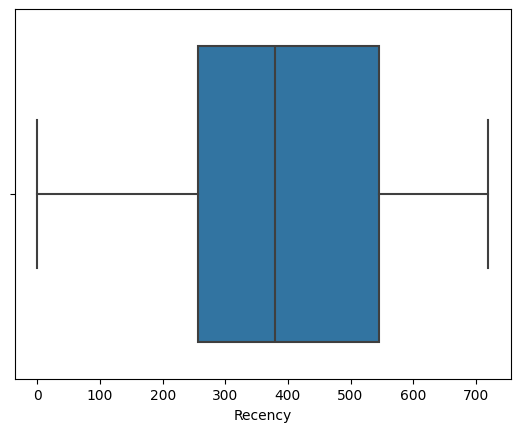

Frequency: 


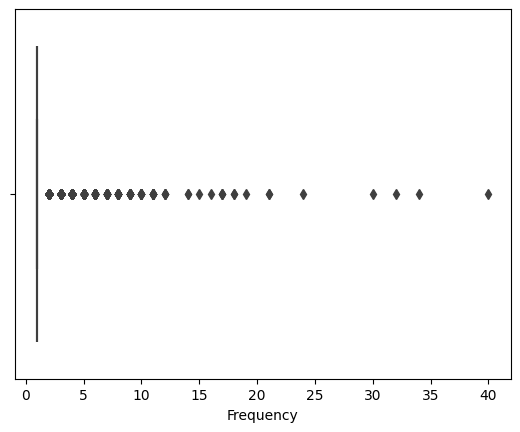

Monetary_value: 


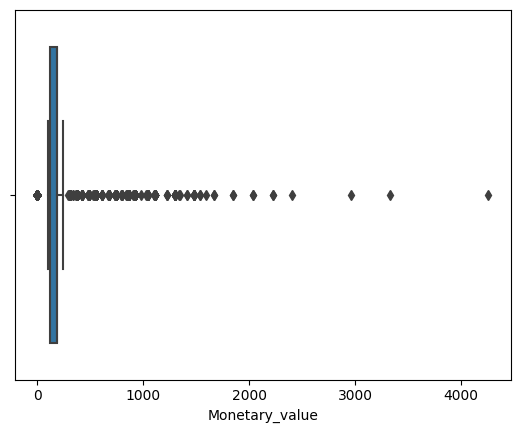

In [19]:

list1 = ['Recency','Frequency','Monetary_value']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=finaldf[str(i)])
    plt.show()

In [20]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15322 entries, 0 to 15321
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PATIENT_ID      15322 non-null  object 
 1   Recency         15322 non-null  int64  
 2   Frequency       15322 non-null  int64  
 3   Monetary_value  15322 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 598.5+ KB


In [21]:

# remove the customer id column
new_df = finaldf[['Recency','Frequency','Monetary_value']]
# remove outliers using z-score. 
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]

In [22]:
new_df.head()

,Recency,Frequency,Monetary_value
0,349,2,370.0
1,677,1,185.0
2,568,1,185.0
3,369,1,185.0
4,402,1,0.0


In [23]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14913 entries, 0 to 15321
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Recency         14913 non-null  int64  
 1   Frequency       14913 non-null  int64  
 2   Monetary_value  14913 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 466.0 KB


In [24]:

# new_df = new_df.drop_duplicates()
col_names = ['Recency','Frequency','Monetary_value']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

In [25]:
scaled_features.head()

,Recency,Frequency,Monetary_value
0,-0.173071,1.104671,1.575851
1,1.500467,-0.435527,0.139366
2,0.944321,-0.435527,0.139366
3,-0.071026,-0.435527,0.139366
4,0.097348,-0.435527,-1.297119


In [26]:
scaled_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14913 entries, 0 to 14912
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Recency         14913 non-null  float64
 1   Frequency       14913 non-null  float64
 2   Monetary_value  14913 non-null  float64
dtypes: float64(3)
memory usage: 349.7 KB


Text(0, 0.5, 'Inertia')

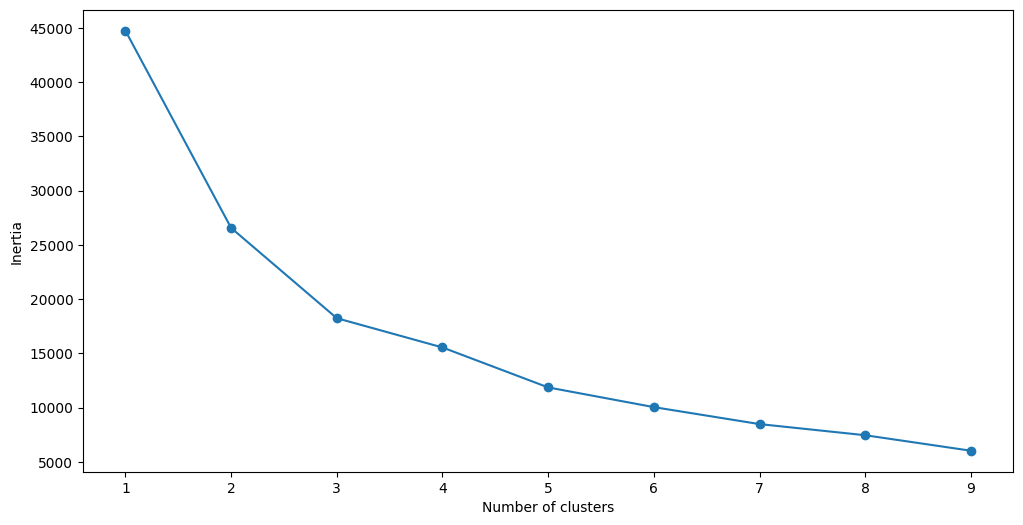

In [27]:
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [46]:
# First, we build a model with 4 clusters
kmeans = KMeans( n_clusters = 5, init='k-means++')
kmeans.fit(scaled_features)

KMeans(n_clusters=5)

In [47]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.4278714834601532


In [48]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

In [49]:
frame.head()

,Recency,Frequency,Monetary_value,cluster
0,349,2,370.0,1
1,677,1,185.0,2
2,568,1,185.0,2
3,369,1,185.0,3
4,402,1,0.0,0


In [50]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14913 entries, 0 to 15321
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Recency         14913 non-null  int64  
 1   Frequency       14913 non-null  int64  
 2   Monetary_value  14913 non-null  float64
 3   cluster         14913 non-null  int32  
dtypes: float64(1), int32(1), int64(2)
memory usage: 1.0 MB


In [77]:
palette = sns.color_palette("tab10", n_colors=avg_df['cluster'].nunique())
color_mapping = {cluster: palette[i] for i, cluster in enumerate(sorted(cluster_counts.index))}

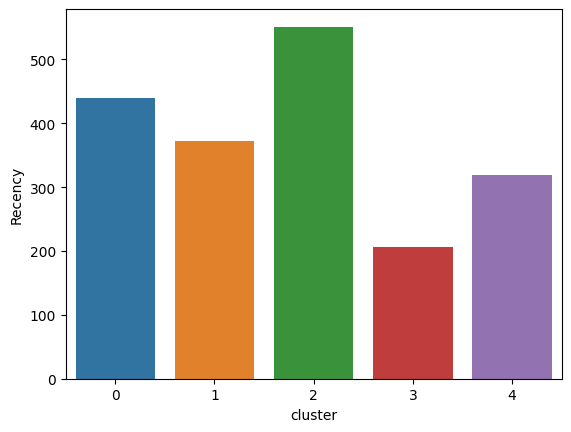

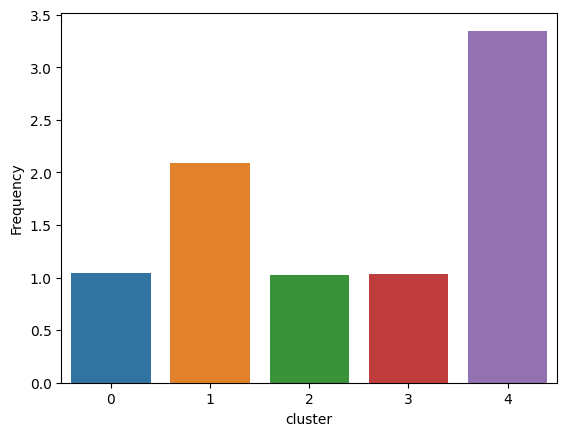

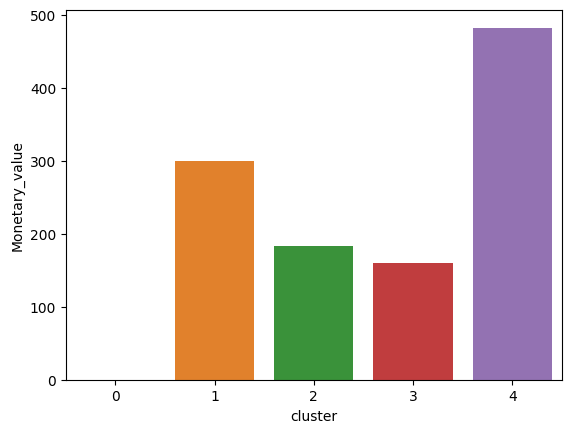

In [75]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df, palette=palette)
    plt.show()

In [34]:
# Super Users (Cluster 1): Patients with the highest monetary value, frequency and moderate recency. We might need a further deep dive on these clients to see what they have consulted for and what message we want to send them to improve their recency. 
# Loyal Users (Cluster 2): Users with an above moderate monetary value, frequency and recency. 
# At Risk Users (Cluster 5): Patients that don't consult often (low frequency and monetary value) and haven't consulted recently either (low recency). 
# Recent Users (Cluster 0): This group is categorised by high recency and low frequency and monetary value. These guys might need a particular messaging urging them to come back. It might be interesting to study the experience of these users. Seems like most of them are no-charge consults.
# Clusters 3 and 4 have similar moderate monetary value and frequency however cluster 4 categorises recent users in this cohort

In [52]:
finaldf_with_clusters = pd.merge(finaldf, frame[['cluster']], left_index=True, right_index=True, how='inner')


In [53]:
finaldf_with_clusters.head()

,PATIENT_ID,Recency,Frequency,Monetary_value,cluster
0,0002c75e-38ea-458e-9add-3217ee3fcd34,349,2,370.0,1
1,0005efd0-ea28-40dc-93e3-de924eb5fac6,677,1,185.0,2
2,00078615-422c-4cc7-95cc-6e4014a382d5,568,1,185.0,2
3,000aed5d-7b65-4f6b-a584-5059b24927f3,369,1,185.0,3
4,000f93c0-36fe-4bde-8fed-7d72f0a54be0,402,1,0.0,0


In [54]:
finaldf_with_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14913 entries, 0 to 15321
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PATIENT_ID      14913 non-null  object 
 1   Recency         14913 non-null  int64  
 2   Frequency       14913 non-null  int64  
 3   Monetary_value  14913 non-null  float64
 4   cluster         14913 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 640.8+ KB


In [63]:
df_users = pd.read_sql_query( 
                      """
WITH
DATA    AS (
SELECT
    INVOICE_ID,
    CONSULTATION_ID,
    PATIENT_ID,
    CREATED_AT,
    DENSE_RANK() OVER(PARTITION BY PATIENT_ID ORDER BY CREATED_AT::DATE ASC) AS RN
    FROM ANALYTICS.PROD.STG_KENA__INVOICES
    ORDER BY PATIENT_ID ASC, CREATED_AT ASC
),
USERS           AS (
SELECT
    USER_ID                 AS PATIENT_ID,
    CREATED_AT              AS REGISTERED_AT,
    CASE WHEN MARKING_CONSTENT_ACCEPTED_AT IS NOT NULL THEN TRUE
        ELSE FALSE
    END                     AS MARKETING_CONSENT,
    ID_NUMBER,
    PATIENT_AGE,
    AGE_GROUP,
    CASE
        WHEN SEX = 0 THEN 'Male'
        when SEX = 1 THEN 'Female'
    ELSE 'Unspecified'
    END                     AS GENDER
    FROM ANALYTICS.PROD.STG_KENA_CLINIC__USERS
    WHERE ID_NUMBER IS NOT NULL
)
SELECT
    U.*,
    D.CREATED_AT            AS INVOICED_AT,
    DATEDIFF(DAY, U.REGISTERED_AT, D.CREATED_AT)            AS DAYS_TO_FIRST_CONSULT, 
    CASE
        WHEN DAYS_TO_FIRST_CONSULT = 0 THEN 'Same Day'
        WHEN DAYS_TO_FIRST_CONSULT > 0 AND DAYS_TO_FIRST_CONSULT <= 7 THEN '1st Week'
        WHEN DAYS_TO_FIRST_CONSULT > 7 AND DAYS_TO_FIRST_CONSULT <= 14 THEN '2nd Week'
        WHEN DAYS_TO_FIRST_CONSULT > 14 AND DAYS_TO_FIRST_CONSULT <= 21 THEN '3rd Week'
        WHEN DAYS_TO_FIRST_CONSULT > 21 AND DAYS_TO_FIRST_CONSULT <= 28 THEN '4th Week'
        WHEN DAYS_TO_FIRST_CONSULT > 28 AND DAYS_TO_FIRST_CONSULT <= 58 THEN '1 - 2 Months'
        WHEN DAYS_TO_FIRST_CONSULT > 58 AND DAYS_TO_FIRST_CONSULT <= 88 THEN '2 - 3 Months'
        WHEN DAYS_TO_FIRST_CONSULT > 88 AND DAYS_TO_FIRST_CONSULT <= 238 THEN '3 - 6 Month'
        WHEN DAYS_TO_FIRST_CONSULT > 238  THEN 'More than 6 Months'
    END                             AS DAYS_TO_FIRST_CONSULT_BUCKET
    FROM USERS          U
        JOIN DATA      D
        ON U.PATIENT_ID = D.PATIENT_ID
        AND RN = 1
 """, con = conn)
df_users.head()

/var/folders/f5/t60lbx3s3z57_j6p74br402w0000gn/T/ipykernel_66642/3196969356.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_users = pd.read_sql_query(


,PATIENT_ID,REGISTERED_AT,MARKETING_CONSENT,ID_NUMBER,PATIENT_AGE,AGE_GROUP,GENDER,INVOICED_AT,DAYS_TO_FIRST_CONSULT,DAYS_TO_FIRST_CONSULT_BUCKET
0,50305f14-b6a5-4ad3-8e43-0c80f26f4219,2024-02-06 12:09:01.366832,True,0403160771081,20,20 - 29,Female,2024-02-06 12:54:39.502449,0,Same Day
1,c9642038-aeeb-4083-b663-f565b70d1949,2024-02-05 13:30:36.285938,True,9303316040087,31,30 - 39,Male,2024-02-05 15:45:47.477894,0,Same Day
2,ef7df8b2-86b2-41ee-b7d5-d140515807e2,2024-02-05 10:44:37.467135,False,8907090115088,35,30 - 39,Female,2024-02-05 11:15:03.976831,0,Same Day
3,cf89c879-7a54-40c3-9e0d-0f4e9721e56a,2024-02-02 21:51:06.340638,False,9503290239080,29,20 - 29,Female,2024-02-03 17:01:45.043419,1,1st Week
4,7f7ef9dd-efe9-4781-b059-7f5da7e3b48d,2024-01-31 13:36:42.427183,False,0310180452081,21,20 - 29,Female,2024-01-31 14:06:06.993417,0,Same Day


In [64]:
final_user_df_with_clusters = pd.merge(finaldf_with_clusters, df_users, on='PATIENT_ID', how='inner')

In [65]:
final_user_df_with_clusters.head()

,PATIENT_ID,Recency,Frequency,Monetary_value,cluster,REGISTERED_AT,MARKETING_CONSENT,ID_NUMBER,PATIENT_AGE,AGE_GROUP,GENDER,INVOICED_AT,DAYS_TO_FIRST_CONSULT,DAYS_TO_FIRST_CONSULT_BUCKET
0,0002c75e-38ea-458e-9add-3217ee3fcd34,349,2,370.0,1,2023-08-08 06:22:59.589984,True,0006095133085,23,20 - 29,Male,2023-08-08 08:50:00.163988,0,Same Day
1,0005efd0-ea28-40dc-93e3-de924eb5fac6,677,1,185.0,2,2024-07-01 08:25:26.352143,True,9808130476085,26,20 - 29,Female,2024-07-01 09:19:19.116604,0,Same Day
2,00078615-422c-4cc7-95cc-6e4014a382d5,568,1,185.0,2,2024-03-14 08:09:39.458979,False,9308150095089,31,30 - 39,Female,2024-03-14 09:02:27.055010,0,Same Day
3,000aed5d-7b65-4f6b-a584-5059b24927f3,369,1,185.0,3,2023-08-28 17:12:19.328244,False,0206021082089,21,20 - 29,Female,2023-08-28 17:24:40.068728,0,Same Day
4,000f93c0-36fe-4bde-8fed-7d72f0a54be0,402,1,0.0,0,2023-09-28 22:40:06.125082,True,0107131109087,22,20 - 29,Female,2023-09-29 19:53:43.762289,1,1st Week


In [66]:
final_user_df_with_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15172 entries, 0 to 15171
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   PATIENT_ID                    15172 non-null  object        
 1   Recency                       15172 non-null  int64         
 2   Frequency                     15172 non-null  int64         
 3   Monetary_value                15172 non-null  float64       
 4   cluster                       15172 non-null  int32         
 5   REGISTERED_AT                 15172 non-null  datetime64[ns]
 6   MARKETING_CONSENT             15172 non-null  bool          
 7   ID_NUMBER                     15172 non-null  object        
 8   PATIENT_AGE                   15172 non-null  int64         
 9   AGE_GROUP                     15172 non-null  object        
 10  GENDER                        15172 non-null  object        
 11  INVOICED_AT                 

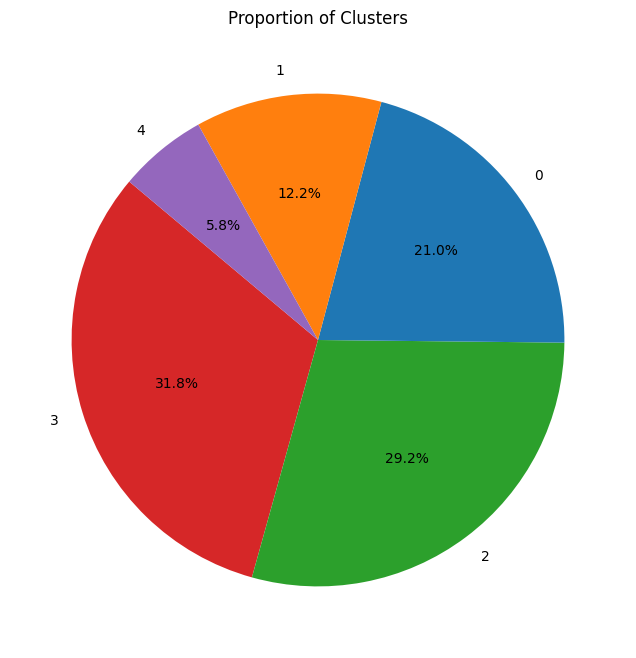

In [78]:
# Pie chart with consistent colors
cluster_counts = final_user_df_with_clusters['cluster'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, 
        colors=[color_mapping[cluster] for cluster in cluster_counts.index])

plt.title('Proportion of Clusters')
plt.show()

In [71]:

filtered_df = final_user_df_with_clusters[final_user_df_with_clusters['cluster'].isin([0, 1, 2, 3, 4])]
filtered_df.to_excel('RFM_Segments_clusters_0_and_1.xlsx', index=False)


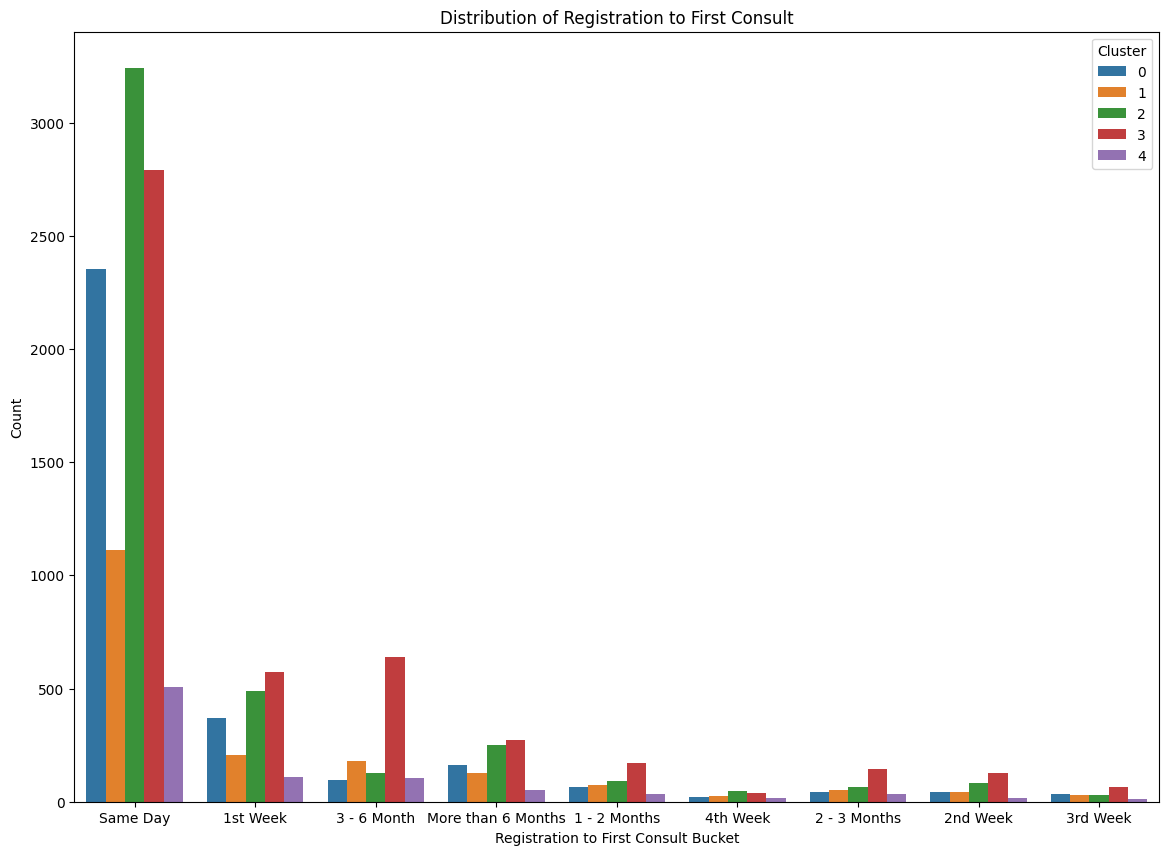

In [73]:
# Plot the count of Age Groups by Cluster
plt.figure(figsize=(14, 10))
sns.countplot(data=final_user_df_with_clusters, x='DAYS_TO_FIRST_CONSULT_BUCKET', hue='cluster')
plt.title('Distribution of Registration to First Consult')
plt.xlabel('Registration to First Consult Bucket')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

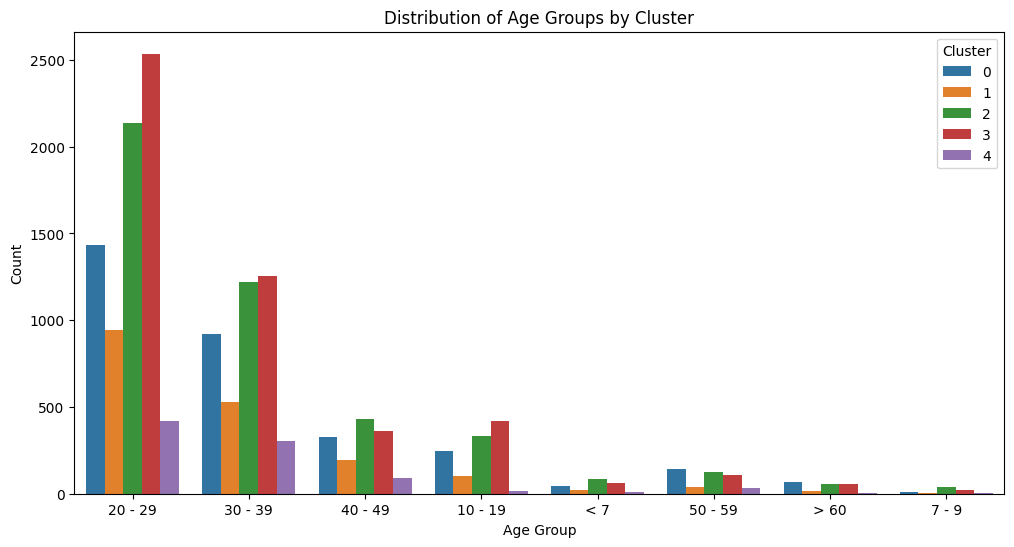

In [61]:
# Plot the count of Age Groups by Cluster
plt.figure(figsize=(12, 6))
sns.countplot(data=final_user_df_with_clusters, x='AGE_GROUP', hue='cluster')
plt.title('Distribution of Age Groups by Cluster')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

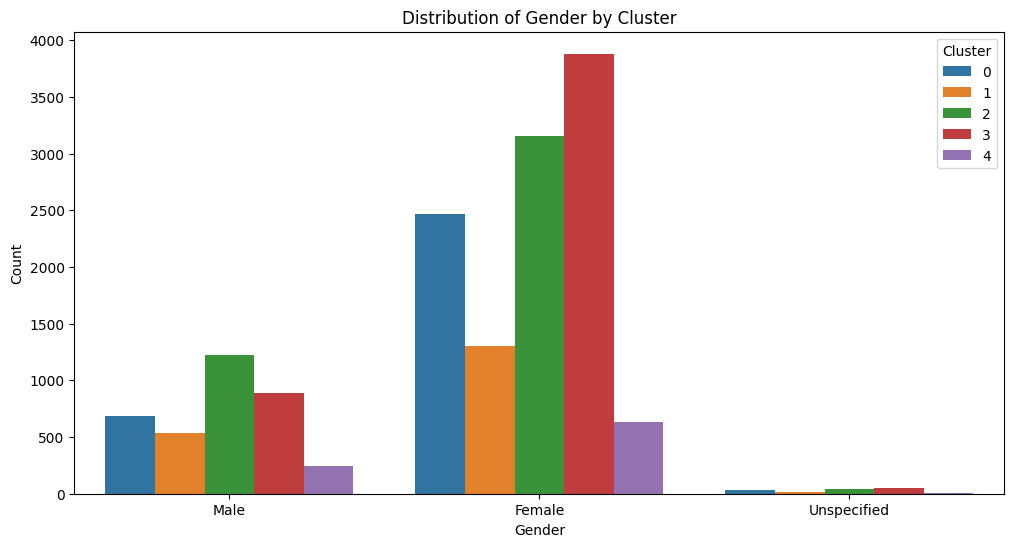

In [62]:
# Plot the count of Genders by Cluster
plt.figure(figsize=(12, 6))
sns.countplot(data=final_user_df_with_clusters, x='GENDER', hue='cluster')
plt.title('Distribution of Gender by Cluster')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()